In [1]:
# decision_tree_learning
import numpy as np
from typing import Tuple

# Load datasets from files
clean_dataset = np.loadtxt("wifi_db/clean_dataset.txt", delimiter="\t")
noisy_dataset = np.loadtxt("wifi_db/noisy_dataset.txt", delimiter=" ")
print(clean_dataset)
print(noisy_dataset)

SIGNAL_COUNT = 7
CLASS_COUNT = 4

def all_same_label(dataset) -> bool:
    # check if all samples have the same label
    for i in range(len(dataset)):
        if dataset[i][SIGNAL_COUNT] != dataset[0][SIGNAL_COUNT]:
            return False    
    return True

def entropy(dataset) -> float:
    # H(D) = - Sum(P(X) * log2(P(X))) for each X in Classes

    if len(dataset) == 0:
        return 0.0
    
    entropy = 0.0
    counts = [0] * CLASS_COUNT

    for i in range(len(dataset)):
        class_index = int(dataset[i][SIGNAL_COUNT]) - 1
        counts[class_index] = counts[class_index] + 1

    for c in range(CLASS_COUNT):
        if counts[c] > 0:
            fraction = counts[c] / len(dataset)
            entropy -= fraction * np.log2(fraction)

    return entropy

def calculate_IG(full_dataset, l_dataset, r_dataset) -> float:
    # IG(D1, D2) = H(D) - H(D1, D2)
    # H(D1, D2) = (|D1|/|D|)H(D1) + (|D2|/|D|)H(D2)

    # H(D) and |D|
    full_entropy = entropy(full_dataset)
    full_length = len(full_dataset)

    # (|D1|/|D|) and (|D2|/|D|)
    if full_length > 0:
        l_fraction = len(l_dataset) / full_length
        r_fraction = len(r_dataset) / full_length
    else:
        l_fraction = 0.0
        r_fraction = 0.0

    # H(D1) and H(D2)
    l_entropy = entropy(l_dataset)
    r_entropy = entropy(r_dataset)

    # H(D1, D2)
    combined_entropy = l_fraction * l_entropy + r_fraction * r_entropy

    # return IG(D1, D2)
    return full_entropy - combined_entropy

def pick_split_value(dataset, attribute: int) -> Tuple[float, float]:
    # find the best value to split by
    highest_IG = 0.0
    best_value = None

    dataset = dataset[dataset[:, attribute].argsort()]

    prev_value = dataset[0][attribute]

    for i in range(1, len(dataset) - 1):
        if dataset[i][attribute] == prev_value:
            continue
        else: 
            prev_value = dataset[i][attribute]
        
        l_dataset = dataset[:i]
        r_dataset = dataset[i:]

        information_gain = calculate_IG(dataset, l_dataset, r_dataset)

        if information_gain > highest_IG:
            highest_IG = information_gain
            best_value = dataset[i][attribute]
    
    return (highest_IG, best_value)

def find_split(dataset):
    # find the best split

    if len(dataset) == 2:
        i = 0
        while dataset[0][i] == dataset[1][i]:
            i = i + 1
        print("Splitting attribute " + str(i) + " at value " + str(max(dataset[0][i], dataset[1][i])))
        return (i, max(dataset[0][i], dataset[1][i]))
    
    best_attribute = 0
    best_value = None
    best_IG = 0.0

    for i in range(SIGNAL_COUNT):
        (information_gain, value) = pick_split_value(dataset, i)

        if value is not None and information_gain > best_IG:
            best_IG = information_gain
            best_attribute = i
            best_value = value

    if best_value is None:
        best_value = dataset[1][best_attribute]
    
    print("Splitting attribute " + str(best_attribute) + " at value " + str(best_value))
    return (best_attribute, best_value)

def decision_tree_learning(dataset, depth) -> Tuple[dict, int]:
    print("Depth: " + str(depth))
    if depth > 50:
        return ({"error": "error"}, depth)
    if all_same_label(dataset):
        print("Value: " + str(dataset[0][SIGNAL_COUNT]))
        return ({"value": dataset[0][SIGNAL_COUNT]}, depth)
    else:
        (split_attribute, split_value) = find_split(dataset)

        l_dataset = dataset[dataset[:,split_attribute] < split_value]
        r_dataset = dataset[dataset[:,split_attribute] >= split_value]

        node = {"split_attribute": split_attribute, "split_value": split_value}

        l_branch, l_depth = decision_tree_learning(l_dataset, depth+1)
        r_branch, r_depth = decision_tree_learning(r_dataset, depth+1)

        node["l_branch"] = l_branch
        node["r_branch"] = r_branch

        return (node, max(l_depth, r_depth))

print(decision_tree_learning(clean_dataset, 0))
# print(decision_tree_learning(noisy_dataset, 0))

[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]
[[-59. -53. -51. ... -79. -87.   4.]
 [-66. -53. -59. ... -81. -79.   1.]
 [-41. -57. -63. ... -66. -65.   2.]
 ...
 [-57. -54. -56. ... -79. -82.   1.]
 [-56. -52. -50. ... -85. -88.   3.]
 [-46. -54. -47. ... -80. -73.   3.]]


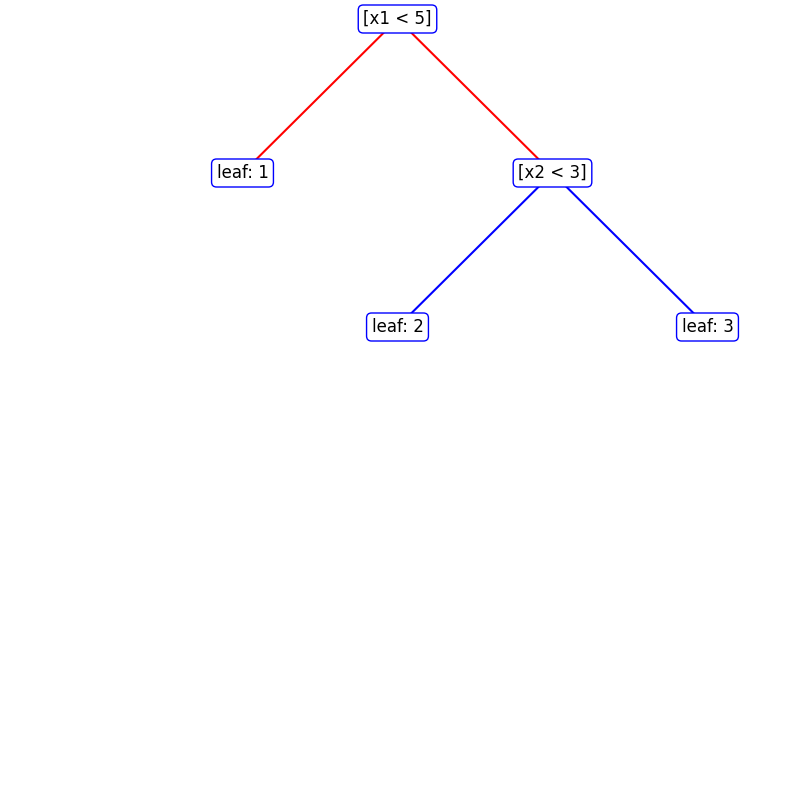

In [21]:
# tree visualiser
import matplotlib.pyplot as plt
# adjust size here later to make it fit depending on the tree depth
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis("off")

def plot_node(node, x, y, line_color):
    if line_color == "blue":
        line_color = "red"
    else:
        line_color = "blue"
    if "value" in node:
        ax.annotate(f"leaf: {node["value"]}", (x, y), fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
    else:
        ax.annotate(f"[x{node['split_attribute']} < {node['split_value']}]", (x, y), fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
        plot_node(node["l_branch"], x-2, y-2, line_color)
        plot_node(node["r_branch"], x+2, y-2, line_color)
        ax.add_line(plt.Line2D((x, x-2), (y, y-2), c=line_color))
        ax.add_line(plt.Line2D((x, x+2), (y, y-2), c=line_color))

demo_tree = {"split_attribute": 1, "split_value": 5, "l_branch": {"value": 1}, "r_branch": {"split_attribute": 2, "split_value": 3, "l_branch": {"value": 2}, "r_branch": {"value": 3}}}
plot_node(demo_tree, 5, 10, "blue")
    

In [ ]:
# evaluation function

In [ ]:
# classification metrics generator